In [1]:
from common import *
import torch
import numpy as np
import glob
import os
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
import matplotlib.pyplot as plt
import matplotlib as mpl
from collections import defaultdict, OrderedDict

In [2]:
# Set font properties for academic style
mpl.rcParams['font.family'] = 'serif'  # Use a serif font
mpl.rcParams['font.serif'] = ['DejaVu Serif']  # Specify a commonly available serif font
mpl.rcParams['font.size'] = 12  # Set default font size

# Data Ingest

In [3]:
# Create the dataloaders

# Create datasets using ImageFolder
test_dataset_unaltered = datasets.ImageFolder(root='animals10-test', transform=unaltered_transforms)
test_dataset_altered = datasets.ImageFolder(root='animals10-test', transform=altered_transforms)

# Create DataLoaders
test_loader_unaltered = DataLoader(test_dataset_unaltered, batch_size=32, shuffle=False)
test_loader_altered = DataLoader(test_dataset_altered, batch_size=32, shuffle=False)

In [4]:
# Initialize an empty dictionary
confusion_matrices = {}

# Use glob to find all matching .npy files
for file_path in glob.glob('*_confusion_matrix.csv.npy'):
    # Extract the file name without the extension
    file_name = os.path.splitext(os.path.basename(file_path))[0]
    experiment_name = '_'.join(file_name.split('_')[:-2])
    # Load the .npy file
    confusion_matrix = np.load(file_path)
    
    # Store it in the dictionary
    confusion_matrices[experiment_name] = confusion_matrix

# Now confusion_matrices contains all loaded confusion matrices

In [5]:
#Loads Grahmians

# Specify the directory where your .npy files are stored
directory = '.'

# Initialize a defaultdict to hold lists for each layer
layers_data = defaultdict(OrderedDict)

# Iterate through all files in the specified directory
for filename in os.listdir(directory):
    if filename.endswith('grahmian.npy'):
        # Extract the experiment name and layer name from the filename
        base_name = filename[:-4]  # Remove the .npy extension
        parts = base_name.split('_')
        
        # Ensure there are at least two parts (experiment name and layer name)
        if len(parts) < 2:
            continue
        
        layer_name = parts[-2]  # Second to last part is the layer name
        experiment_name = '_'.join(parts[:-2])  # Join all but the last two parts for the experiment name
        
        # Load the .npy file using mmap
        file_path = os.path.join(directory, filename)
        matrix = np.load(file_path, mmap_mode='r')
        
        # Create a dictionary with the experiment name as the key and the matrix as the value
        layers_data[layer_name][experiment_name]= matrix

In [6]:
# Directory containing the loss files
losses_directory = '.'  # Replace with your actual directory

# Initialize an empty dictionary to store losses
losses_dict = {}

# Iterate through all files in the specified directory
for filename in os.listdir(losses_directory):
    if filename.endswith('_losses.npy'):
        # Extract the experiment name (remove the '_losses.npy' part)
        experiment_name = filename[:-len('_losses.npy')]
        
        # Load the numpy array from the file
        losses = np.load(os.path.join(losses_directory, filename))
        
        # Store in the dictionary
        losses_dict[experiment_name] = losses

# losses_dict now contains all the loaded losses indexed by experiment name

# Figure Generation

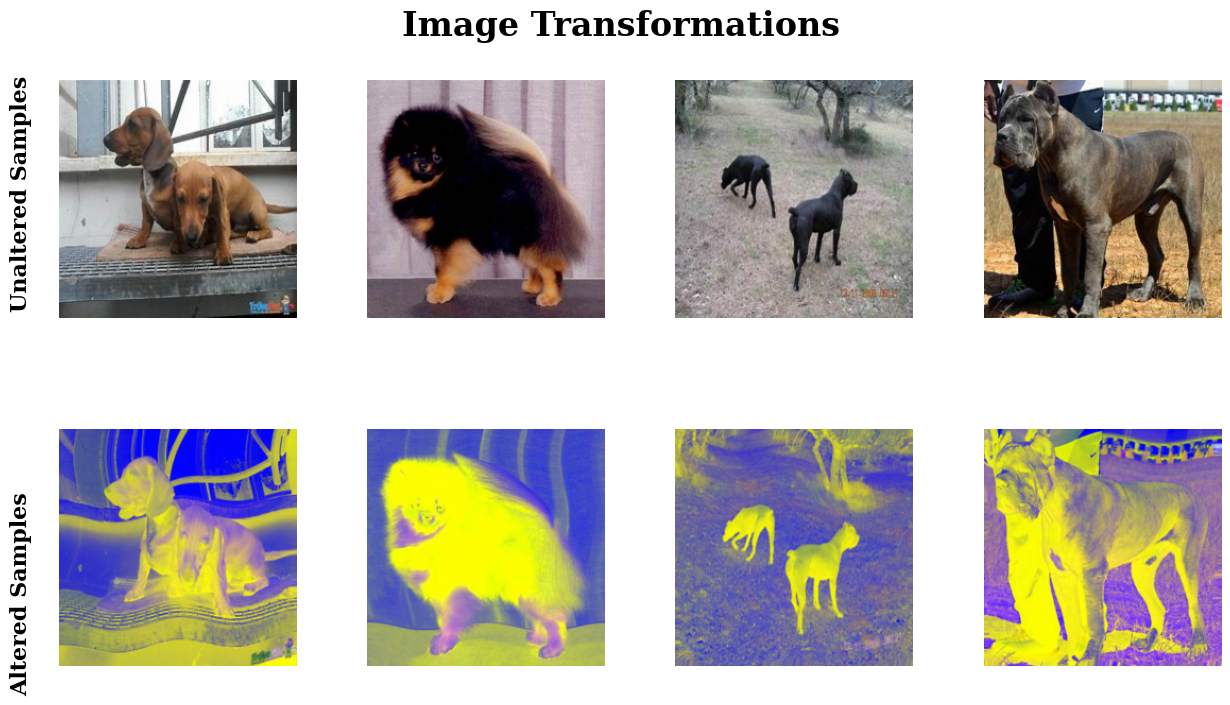

In [7]:
def plot_samples(loader, ax, title_prefix):
    images, _ = next(iter(loader))
    for i in range(3, 7):
        ax[i-3].imshow(images[i].permute(1, 2, 0))  # Permute to (H, W, C)
        ax[i-3].axis('off')

# Create the figure and axes
fig, axs = plt.subplots(2, 4, figsize=(15, 8))
fig.suptitle('Image Transformations', fontsize=24, fontweight='bold', y=0.95)

# Plot unaltered samples
plot_samples(test_loader_unaltered, axs[0], 'Unaltered')

# Plot altered samples
plot_samples(test_loader_altered, axs[1], 'Altered')

# Add row labels
fig.text(0.1, 0.72, 'Unaltered Samples', fontsize=16, fontweight='bold', va='center', ha='center', rotation=90)
fig.text(0.1, 0.22, 'Altered Samples', fontsize=16, fontweight='bold', va='center', ha='center', rotation=90)

# Adjust spacing for better readability
plt.subplots_adjust(hspace=0.3, wspace=0.3)

# Optional: Add a grid to subplots for visual guidance
for ax_row in axs:
    for ax in ax_row:
        ax.set_facecolor('#f9f9f9')  # Light background color
        ax.grid(False)

plt.show()

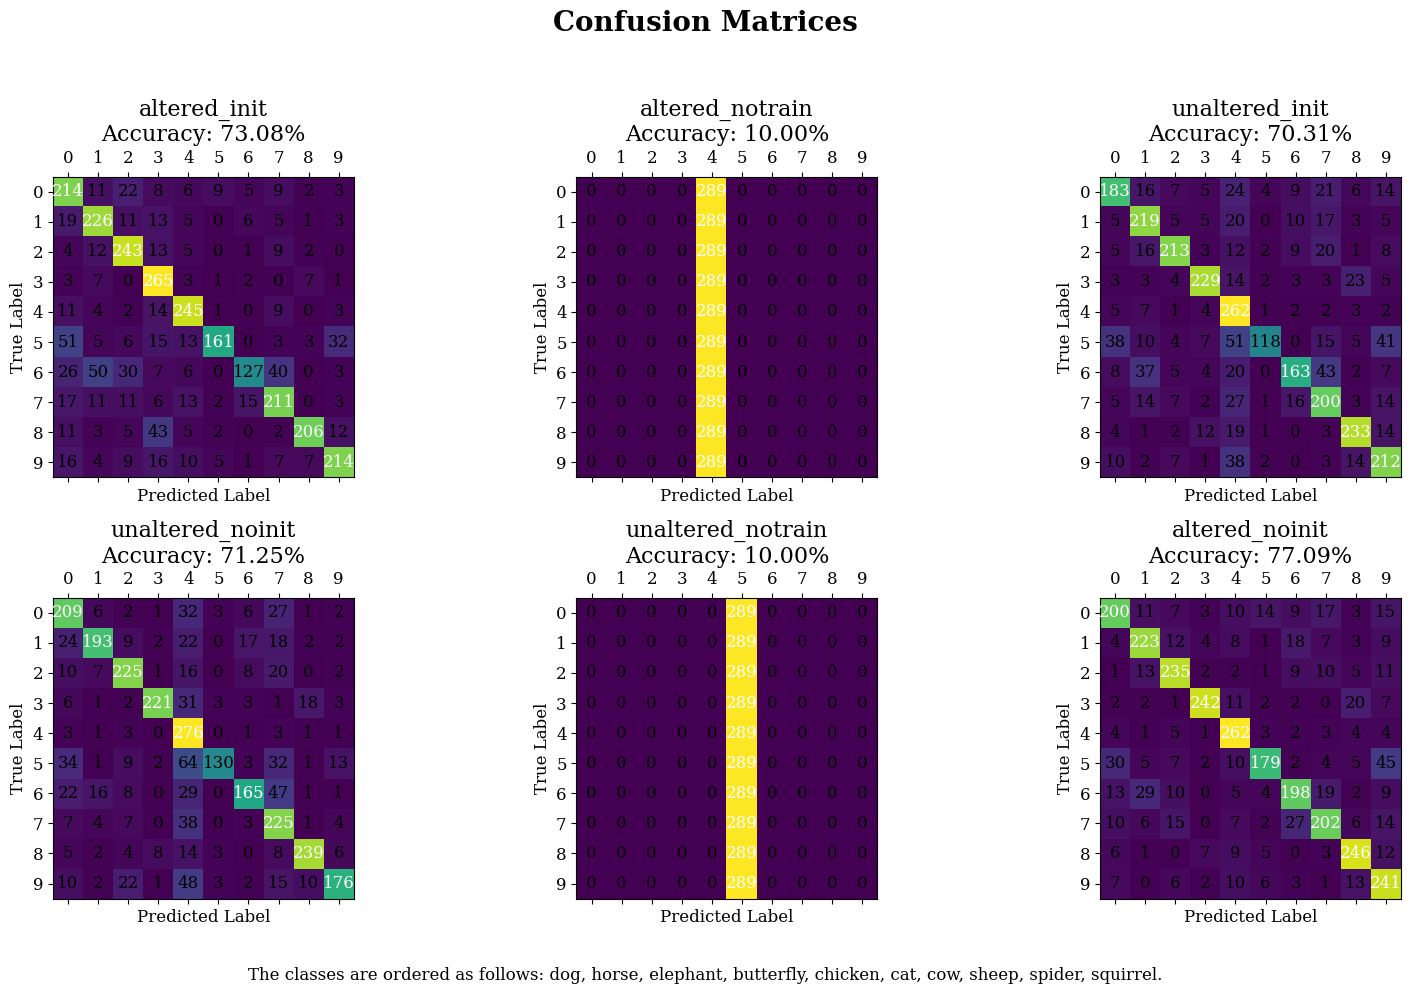

In [8]:
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrices(confusion_matrices, dataset):
    # Number of experiments
    num_experiments = len(confusion_matrices)
    
    # Class mapping
    class_names = {
        0: 'Dog',
        1: 'Horse',
        2: 'Elephant',
        3: 'Butterfly',
        4: 'Chicken',
        5: 'Cat',
        6: 'Cow',
        7: 'Sheep',
        8: 'Spider',
        9: 'Squirrel'
    }

    # Calculate number of rows needed
    num_rows = (num_experiments + 2) // 3  # Ceiling division for rows

    # Create a figure with subplots
    fig, axs = plt.subplots(num_rows, 3, figsize=(15, 5 * num_rows))  # Adjust figure size

    # Flatten the axes array for easier indexing
    axs = axs.flatten()
    fig.suptitle('Confusion Matrices', fontsize=20, fontweight='bold')

    # Narrative subtitle for class ordering at the bottom
    narrative = "The classes are ordered as follows: dog, horse, elephant, butterfly, chicken, cat, cow, sheep, spider, squirrel."
    plt.figtext(0.5, 0.01, narrative, ha='center', fontsize=12)

    for ax, (experiment_name, cm) in zip(axs, confusion_matrices.items()):
        if cm.size == 0:
            ax.set_title(f'{experiment_name}\nNo Data', fontsize=16)
            ax.axis('off')  # Hide the axis
            continue

        cax = ax.matshow(cm, cmap='viridis')

        # Annotate the cells with the numeric values
        for (i, j), val in np.ndenumerate(cm):
            ax.text(j, i, f'{val}', ha='center', va='center', color='white' if val > np.max(cm) / 2 else 'black')

        # Calculate accuracy
        correct_predictions = np.trace(cm)  # Sum of diagonal elements
        total_predictions = np.sum(cm)  # Total number of predictions
        accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0

        # Set title with experiment name and accuracy
        ax.set_title(f'{experiment_name}\nAccuracy: {accuracy:.2%}', fontsize=16)
        ax.set_xlabel('Predicted Label')
        ax.set_ylabel('True Label')

        # Set x-tick and y-tick labels without class names
        ax.set_xticks(np.arange(len(class_names)))
        ax.set_xticklabels(np.arange(len(class_names)))  # Numeric labels for clarity

        ax.set_yticks(np.arange(len(class_names)))
        ax.set_yticklabels(np.arange(len(class_names)))  # Numeric labels for clarity

    # Turn off unused axes
    for i in range(num_experiments, len(axs)):
        axs[i].axis('off')

    plt.tight_layout(rect=[0, 0.05, 1, 0.95])  # Adjust layout
    plt.subplots_adjust(wspace=0.4, hspace=0.4)  # Adjust space between subplots
    plt.show()

# Call the function
plot_confusion_matrices(confusion_matrices, test_dataset_unaltered)


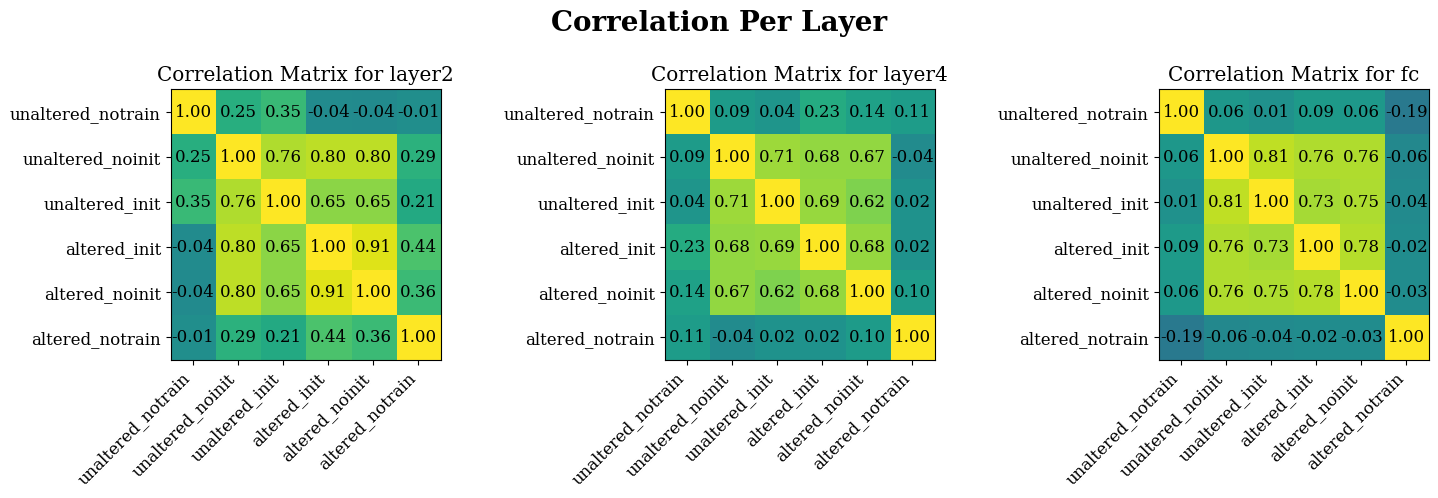

In [15]:
#Computes correlation matrix within a layer set
def compute_correlation_matrix(experiment_dict):
    # Extract the experiment names and their corresponding Gramian matrices
    experiment_names = list(experiment_dict.keys())
    gramian_matrices = [experiment_dict[name] for name in experiment_names]
    
    n = len(gramian_matrices)
    
    # Initialize an empty correlation matrix
    correlation_matrix = np.zeros((n, n))

    # Compute the correlation matrix
    for i in range(n):
        for j in range(i, n):  # Only compute upper triangle
            # Compute the correlation
            corr = np.corrcoef(gramian_matrices[i].flatten(), gramian_matrices[j].flatten())[0, 1]
            correlation_matrix[i, j] = corr
            correlation_matrix[j, i] = corr  # Exploit symmetry

    return correlation_matrix, experiment_names

num_layers = len(layers_data)

# Create a figure with a single row of subplots
fig, axs = plt.subplots(1, num_layers, figsize=(5 * num_layers, 5))

# Define the specific order you want
specific_order = ['unaltered_notrain','unaltered_noinit','unaltered_init','altered_init','altered_noinit','altered_notrain']  # Replace with your actual keys

# Iterate through each layer and compute the correlation matrix
for i, layer in enumerate(['layer2','layer4','fc']):
    # Create a sorted version of the inner dictionary based on the specific order
    sorted_data = {key: layers_data[layer][key] for key in specific_order if key in layers_data[layer]}
    
    # Compute the correlation matrix using the sorted data
    matrix, experiment_names = compute_correlation_matrix(sorted_data)
    
    # Plotting the correlation matrix with heatmap
    cax = axs[i].imshow(matrix, cmap='viridis', vmin=-1, vmax=1)
    axs[i].set_xticks(range(len(experiment_names)))
    axs[i].set_yticks(range(len(experiment_names)))
    axs[i].set_xticklabels(experiment_names, rotation=45, ha='right')
    axs[i].set_yticklabels(experiment_names)
    axs[i].set_title(f'Correlation Matrix for {layer}')
    
    # Add annotations for the numeric correlation values
    for (j, k), val in np.ndenumerate(matrix):
        axs[i].text(k, j, f'{val:.2f}', ha='center', va='center', color='black')

# Set the overall title
plt.suptitle('Correlation Per Layer', fontsize=20, fontweight='bold')

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Show the plot
plt.show()


dict_keys(['altered_init', 'altered_notrain', 'unaltered_init', 'unaltered_noinit', 'unaltered_notrain', 'altered_noinit'])


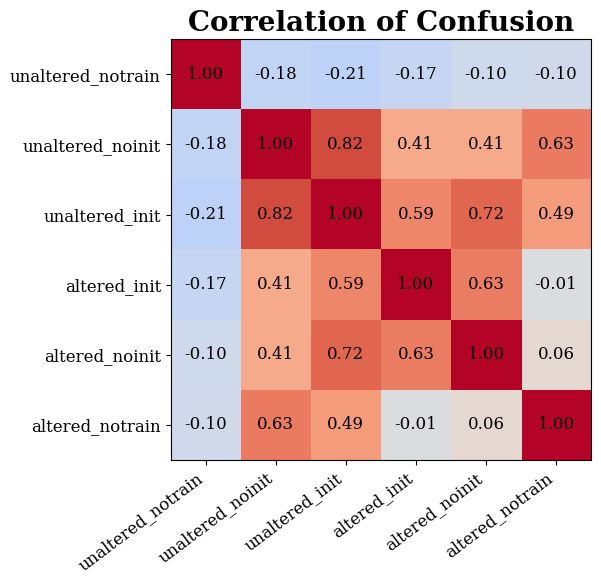

In [21]:
# Create a new dictionary to hold modified confusion matrices
modified_confusion_matrices = {}
print(confusion_matrices.keys())
# Iterate through the original confusion matrices
for key in ['unaltered_notrain','unaltered_noinit','unaltered_init','altered_init','altered_noinit','altered_notrain']:
    # Create a copy of the matrix
    modified_matrix = confusion_matrices[key].copy()
    
    # Set the diagonal elements to zero
    np.fill_diagonal(modified_matrix, 0)

    # Store in the new dictionary
    modified_confusion_matrices[key] = modified_matrix


# Compute the correlation matrix for the modified confusion matrices
correlation_matrix, experiment_names = compute_correlation_matrix(modified_confusion_matrices)

# Create a figure for the plot
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the correlation matrix
cax = ax.imshow(correlation_matrix, cmap='coolwarm', vmin=-1, vmax=1)
ax.set_xticks(range(len(experiment_names)))
ax.set_yticks(range(len(experiment_names)))
ax.set_xticklabels(experiment_names, rotation=37, ha='right',fontsize=12)
ax.set_yticklabels(experiment_names)
ax.set_title('Correlation of Confusion', fontsize=20, fontweight='bold')

# Annotate the cells with the numeric correlation values
for (j, k), val in np.ndenumerate(correlation_matrix):
    ax.text(k, j, f'{val:.2f}', ha='center', va='center', color='black')

# Remove horizontal grid lines
ax.yaxis.grid(False)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()


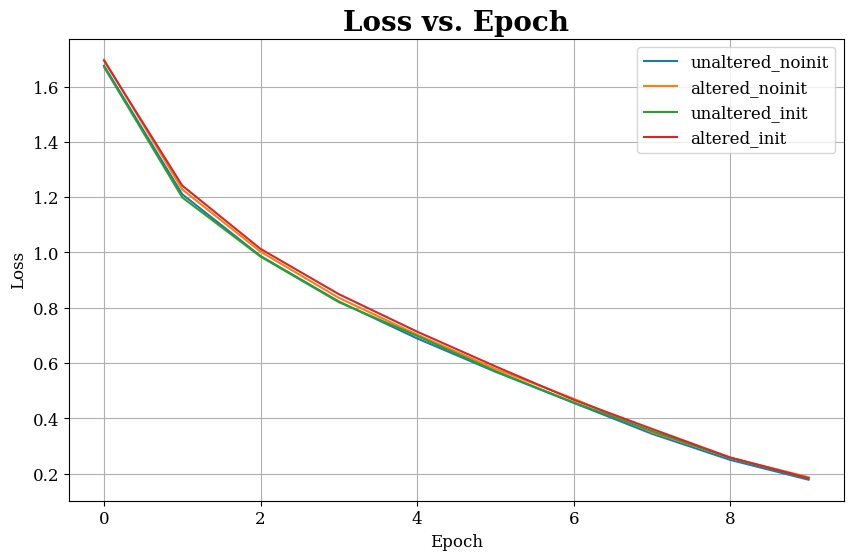

In [11]:
# Create a plot
plt.figure(figsize=(10, 6))

for experiment_name, losses in losses_dict.items():
    plt.plot(losses, label=experiment_name)

# Add labels and title
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epoch', fontsize=20, fontweight='bold')
plt.legend()
plt.grid()
plt.show()